<a href="https://colab.research.google.com/github/emilysongzhang/bootcamp_final/blob/main/Data_Bootcamp_Final_Project_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project**
#### Emily Zhang ez2237
#### Data Bootcamp: Section 001
#### Professor JF Koehler
#### 13 December 2024

### **OBJECTIVES**

**Research Question:**

**Can Rate My Professor be considered a reliable and unbiased resource for evaluating professor performance, or do its inherent biases limit its utility?**

<br />

To address my overarching question, I will follow a 3-step approach:

1. Data Cleaning
2. Exploratory Data Analysis (Hypothesis Tests)
3. Modeling (Predictions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# =============================================================================
# Assume an alpha level of 0.005 as the threshold for statistical significance for all results
# =============================================================================
alpha = 0.005
seed = 15828075
np.random.seed(seed)

professor_df = pd.read_csv("/content/drive/My Drive/data_bootcamp_final_data/rmpNum.csv", header=None)

In [4]:
professor_df.columns = [
    "avg_rating",
    "avg_difficulty",
    "num_rating",
    "receive_pepper",
    "take_again",
    "num_rating_online",
    "is_male",
    "is_female"
]
professor_df.head()

,avg_rating,avg_difficulty,num_rating,receive_pepper,take_again,num_rating_online,is_male,is_female
0,5.0,1.5,2.0,0.0,NaN,0.0,0,1
1,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,3.2,3.0,4.0,0.0,NaN,0.0,1,0
3,3.6,3.5,10.0,1.0,NaN,0.0,0,0
4,1.0,5.0,1.0,0.0,NaN,0.0,0,0


### **Data Cleaning**

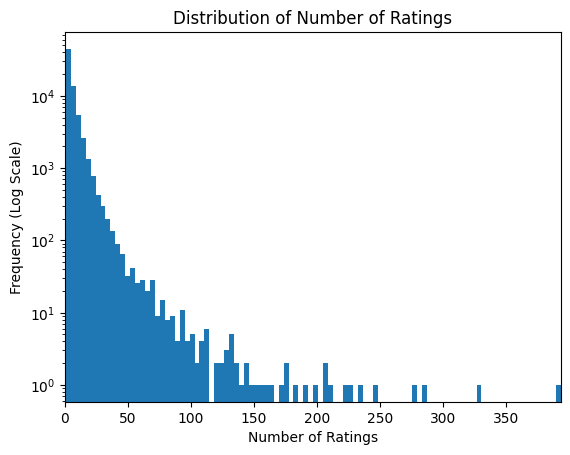

In [5]:
# =============================================================================
# Missing value cleaning
# =============================================================================
professor_df["num_rating"].unique()

num_rating = professor_df["num_rating"]

plt.hist(num_rating, bins=100)
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency (Log Scale)")
plt.yscale("log")
plt.title("Distribution of Number of Ratings")
plt.xlim(0, np.nanmax(num_rating))
plt.show()

# Mean and median of num_rating without nan values
num_rating_nanmean = np.nanmean(professor_df["num_rating"])
num_rating_nanmedian = np.nanmedian(professor_df["num_rating"].median())

professor_wt = professor_df.copy()

# Testing thresholds
test1=professor_df[professor_df["num_rating"]>10]
test2=professor_df[professor_df["num_rating"]<=10]
nan_count1 = test1.isna().sum().sum()
nan_count2 = test2.isna().sum().sum()

# Only keeps num_ratings > 10 and drops all NaN values in the dataframe
professor_wt = professor_wt[professor_wt["num_rating"] > 10].dropna()
professor_wt.shape

# Mean and median of num_rating after nan cleaning and filtering
num_rating_mean = professor_wt["num_rating"].mean()
num_rating_median = professor_wt["num_rating"].median()

### **Exploratory Data Analysis (Hypothesis Tests)**


<ipython-input-6-ba336b3d5c6d>:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  descriptivesContainer_df = pd.concat([descriptivesContainer_df, male_data], ignore_index=True)


u1: 3512290.5, p_u1: 0.0027319691810873
Reject the null hypothesis: Evidence suggests a pro-male bias.


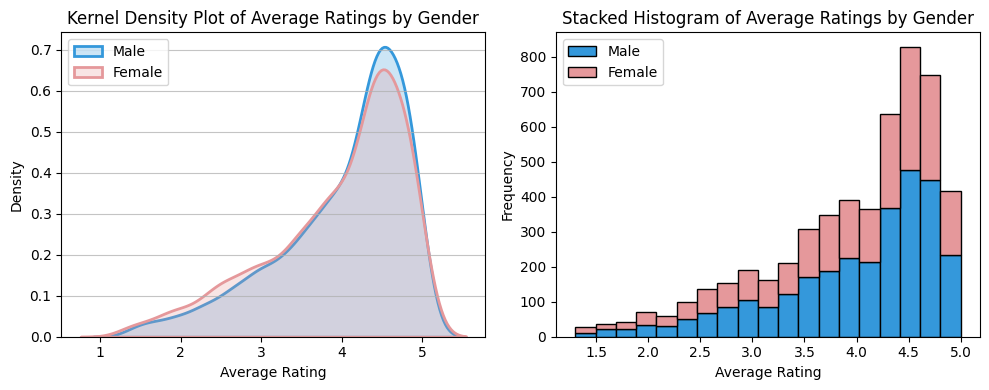

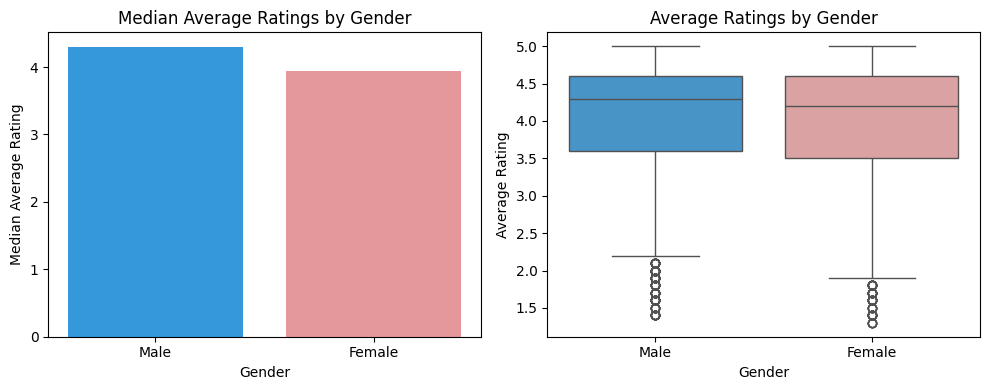

In [6]:
# =============================================================================
# 1. Is there evidence of a pro-male gender bias in this dataset?
# =============================================================================
import seaborn as sns
from scipy.stats import mannwhitneyu

# Removes rows of where is_male and is_female are both 0 and are both 1
professor_wt = professor_wt[~((professor_wt["is_male"] == 0) & (professor_wt["is_female"] == 0))]
professor_wt = professor_wt[~((professor_wt["is_male"] == 1) & (professor_wt["is_female"] == 1))]

male_ratings = professor_wt[professor_wt["is_male"] == 1]["avg_rating"]
female_ratings = professor_wt[professor_wt["is_female"] == 1]["avg_rating"]

descriptivesContainer_df = pd.DataFrame(columns=["group", "median", "sd", "n", "se"])

male_median = np.median(male_ratings)
male_sd = np.std(male_ratings)
male_n = len(male_ratings)
male_se = male_sd/np.sqrt(male_n)

male_data = pd.DataFrame([{
    "group": "Male",
    "median": male_median,
    "sd": male_sd,
    "n": male_n,
    "se": male_se
}])

descriptivesContainer_df = pd.concat([descriptivesContainer_df, male_data], ignore_index=True)

female_median = np.mean(female_ratings)
female_sd = np.std(female_ratings)
female_n = len(female_ratings)
female_se = female_sd/np.sqrt(female_n)

female_data = pd.DataFrame([{
    "group": "Female",
    "median": female_median,
    "sd": female_sd,
    "n": female_n,
    "se": female_se
}])

descriptivesContainer_df = pd.concat([descriptivesContainer_df, female_data], ignore_index=True)

# Performs Mann-Whitney U test to assess if male ratings are significantly greater than female ratings
u1, p_u1 = mannwhitneyu(male_ratings, female_ratings, alternative='greater')

print(f"u1: {u1}, p_u1: {p_u1}")

if p_u1 < alpha:
    print("Reject the null hypothesis: Evidence suggests a pro-male bias.")
else:
    print("Fail to reject the null hypothesis: No evidence of a pro-male bias.")

# COMBINED GRAPHS
bins = np.linspace(min(male_ratings.min(), female_ratings.min()), max(male_ratings.max(), female_ratings.max()), 20)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Density plot
sns.kdeplot(male_ratings, label='Male', fill=True, alpha=0.25, color='#3498db', linewidth=2, ax=axs[0])
sns.kdeplot(female_ratings, label='Female', fill=True, alpha=0.25, color='#E5989B', linewidth=2, ax=axs[0])
axs[0].set_xlabel('Average Rating')
axs[0].set_ylabel('Density')
axs[0].set_title('Kernel Density Plot of Average Ratings by Gender')
axs[0].legend(loc='upper left')
axs[0].grid(axis='y', alpha=0.75)

# Stacked histogram
axs[1].hist(
    [male_ratings, female_ratings],
    bins=bins,
    stacked=True,
    color=["#3498db", "#E5989B"],
    label=["Male", "Female"],
    edgecolor='black',
)
axs[1].set_xlabel("Average Rating")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Stacked Histogram of Average Ratings by Gender")
axs[1].legend(loc="upper left")

plt.tight_layout()
plt.show();

categories1 = ["Male", "Female"]
medians1 = [male_median, female_median]

gender_rating = pd.DataFrame({
    "Ratings": np.concatenate([male_ratings, female_ratings]),
    "Gender": ["Male"] * len(male_ratings) + ["Female"] * len(female_ratings)
})

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Barplot
axes[0].bar(categories1, medians1, color=["#3498db", "#E5989B"])
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Median Average Rating")
axes[0].set_title("Median Average Ratings by Gender")

# Boxplot
sns.boxplot(data=gender_rating, x="Gender", y="Ratings", hue= "Gender", palette=["#3498db", "#E5989B"], ax=axes[1])
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Average Rating")
axes[1].set_title("Average Ratings by Gender")

plt.tight_layout()
plt.show();

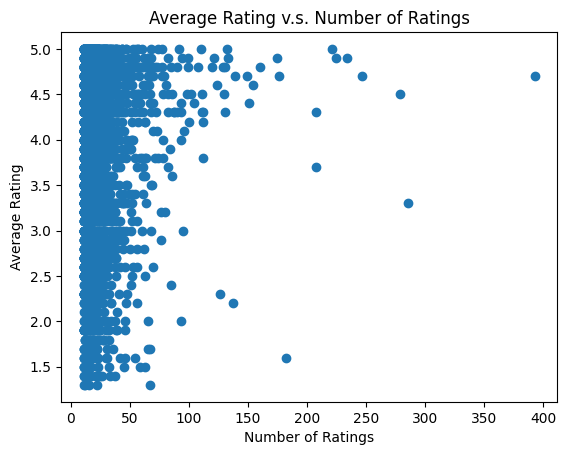

u2: 3511500.5, p_u2: 0.05068387140892033
Fail to reject the null hypothesis: No significant evidence that professor experience impacts ratings.


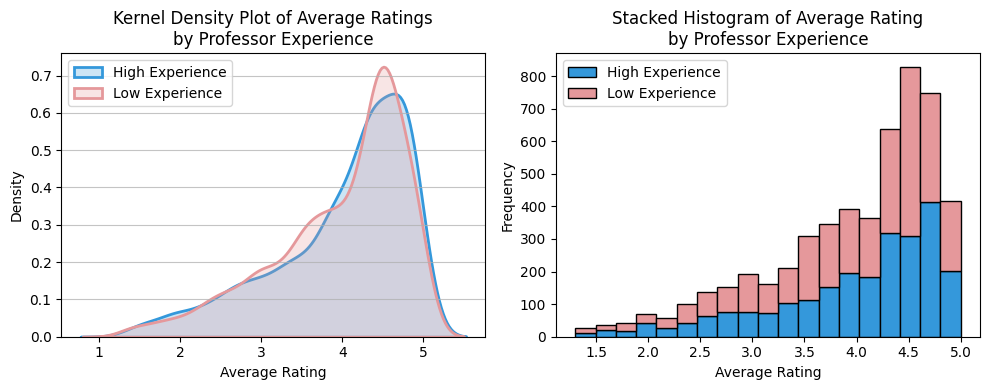

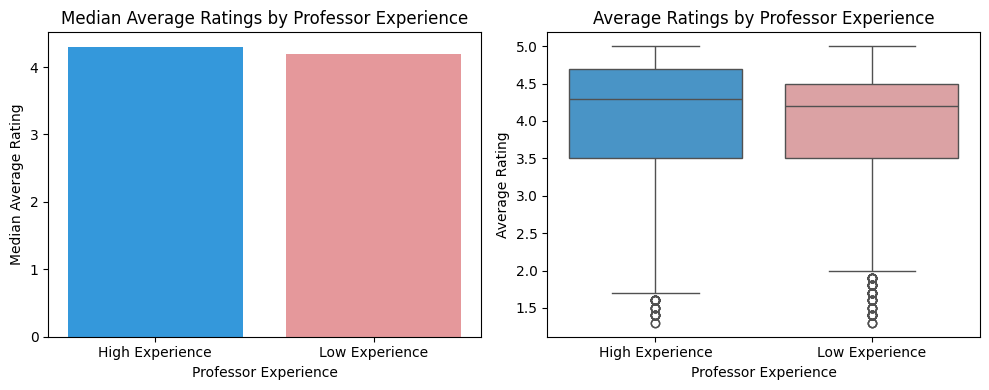

In [7]:
#%%
# =============================================================================
# 2. Is there an effect of experience on the quality of teaching?
# =============================================================================

# I am using number of ratings as a proxy variable for quality of teaching

# Scatterplot of num_ratings v.s. avg_rating
plt.scatter(professor_wt["num_rating"], professor_wt["avg_rating"])
plt.xlabel("Number of Ratings")
plt.ylabel("Average Rating")
plt.title("Average Rating v.s. Number of Ratings")
plt.show()


# Separates professors with high experience and professors with low experience
high_experience = professor_wt[professor_wt["num_rating"] > num_rating_median]["avg_rating"]
low_experience = professor_wt[professor_wt["num_rating"] <= num_rating_median]["avg_rating"]

high_experience_median = np.median(high_experience)
high_experience_sd = np.std(high_experience)
high_experience_n = len(high_experience)
high_experience_se = high_experience_sd/np.sqrt(high_experience_n)

high_experience_data = pd.DataFrame([{
    "group": "High Experience",
    "median": high_experience_median,
    "sd": high_experience_sd,
    "n": high_experience_n,
    "se": high_experience_se
}])

descriptivesContainer_df = pd.concat([descriptivesContainer_df, high_experience_data], ignore_index=True)

low_experience_median = np.median(low_experience)
low_experience_sd = np.std(low_experience)
low_experience_n = len(low_experience)
low_experience_se = low_experience_sd/np.sqrt(low_experience_n)

low_experience_data = pd.DataFrame([{
    "group": "Low Experience",
    "median": low_experience_median,
    "sd": low_experience_sd,
    "n": low_experience_n,
    "se": low_experience_se
}])

descriptivesContainer_df = pd.concat([descriptivesContainer_df, low_experience_data], ignore_index=True)

# Performs Mann-Whitney U test to assess if there is a difference between avg_rating for professors with high experience and professors with low experience
u2, p_u2 = mannwhitneyu(high_experience, low_experience, alternative='two-sided')

print(f"u2: {u2}, p_u2: {p_u2}")

if p_u2 < alpha:
    print("Reject the null hypothesis: Evidence suggests a significant difference in ratings based on professor experience.")
else:
    print("Fail to reject the null hypothesis: No significant evidence that professor experience impacts ratings.")

# COMBINED GRAPHS
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Density plot
sns.kdeplot(high_experience, label='High Experience', fill=True, alpha=0.25, color='#3498db', linewidth=2, ax=axs[0])
sns.kdeplot(low_experience, label='Low Experience', fill=True, alpha=0.25, color='#E5989B', linewidth=2, ax=axs[0])
axs[0].set_xlabel('Average Rating')
axs[0].set_ylabel('Density')
axs[0].set_title('Kernel Density Plot of Average Ratings\nby Professor Experience')
axs[0].legend(loc='upper left')
axs[0].grid(axis='y', alpha=0.75)

# Stacked histogram
bins = np.linspace(min(high_experience.min(), low_experience.min()), max(high_experience.max(), low_experience.max()), 20)
axs[1].hist(
    [high_experience, low_experience],
    bins=bins,
    stacked=True,
    color=["#3498db", "#E5989B"],
    label=["High Experience", "Low Experience"],
    edgecolor='black'
)
axs[1].set_xlabel("Average Rating")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Stacked Histogram of Average Rating\nby Professor Experience")
axs[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

categories2 = ["High Experience", "Low Experience"]
medians2 = [np.median(high_experience), np.median(low_experience)]

rating_experience = pd.DataFrame({
    "Rating": np.concatenate([high_experience, low_experience]),
    "Professor Experience": (["High Experience"] * len(high_experience) +
                              ["Low Experience"] * len(low_experience))
})

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Barplot
axes[0].bar(categories2, medians2, color=["#3498db", "#E5989B"])
axes[0].set_xlabel("Professor Experience")
axes[0].set_ylabel("Median Average Rating")
axes[0].set_title("Median Average Ratings by Professor Experience")

# Boxplot
sns.boxplot(data=rating_experience, x="Professor Experience", y="Rating",
            hue= "Professor Experience", palette=["#3498db", "#E5989B"], ax=axes[1])
axes[1].set_xlabel("Professor Experience")
axes[1].set_ylabel("Average Rating")
axes[1].set_title("Average Ratings by Professor Experience")

plt.tight_layout()
plt.show()

u4: 269794.5, p_u4: 0.001212314294319596
Reject the null hypothesis: Evidence suggests a significant difference in ratings based on teaching modality.


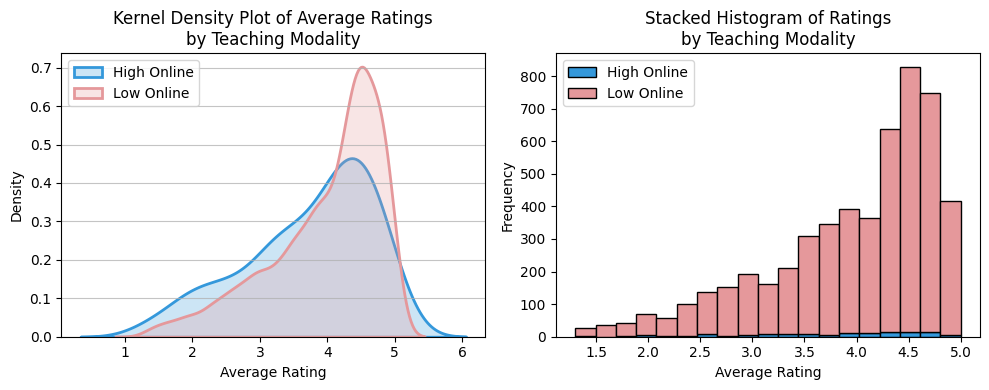

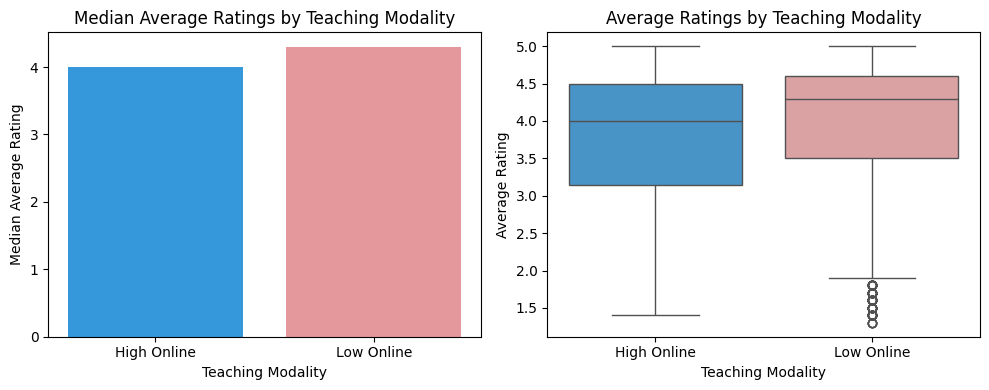

In [8]:
# =============================================================================
# 3. Do professors who teach a lot of classes in the online modality receive higher or lower ratings than those who don’t?
# =============================================================================

# Classification of teaching modality
def classify_modality(row):
    online_ratio = row['num_rating_online'] / row['num_rating']
    if online_ratio >= 0.5:
        return 'High Online'
    else:
        return 'Low Online'

professor_wt['teaching_modality'] = professor_wt.apply(classify_modality, axis=1)

high_online = professor_wt[professor_wt['teaching_modality'] == 'High Online']['avg_rating']
low_online = professor_wt[professor_wt['teaching_modality'] == 'Low Online']['avg_rating']

# Calculate median, standard deviation, and sample size
high_online_median, high_online_sd, high_online_n = np.median(high_online), np.std(high_online), len(high_online)
low_online_median, low_online_sd, low_online_n = np.median(low_online), np.std(low_online), len(low_online)

teaching_modality_data = pd.DataFrame({
    "group": ["High Online", "Low Online"],
    "median": [high_online_median, low_online_median],
    "sd": [high_online_sd, low_online_sd],
    "n": [high_online_n, low_online_n],
    "se": [
        high_online_sd / np.sqrt(high_online_n),
        low_online_sd / np.sqrt(low_online_n),
    ],
})

descriptivesContainer_df = pd.concat([descriptivesContainer_df, teaching_modality_data], ignore_index=True)

# Performs Mann-Whitney U test to assess if there is a difference between avg_rating for professors who teach a lot of online classes and professors who do not teach a lot of online classes
u4, p_u4 = mannwhitneyu(high_online, low_online, alternative='two-sided')

print(f"u4: {u4}, p_u4: {p_u4}")

if p_u4 < alpha:
    print("Reject the null hypothesis: Evidence suggests a significant difference in ratings based on teaching modality.")
else:
    print("Fail to reject the null hypothesis: No significant evidence that teaching modality impacts ratings.")

# COMBINED GRAPHS

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Density plot
sns.kdeplot(high_online, label='High Online', fill=True, alpha=0.25, color='#3498db', linewidth=2, ax=axs[0])
sns.kdeplot(low_online, label='Low Online', fill=True, alpha=0.25, color='#E5989B', linewidth=2, ax=axs[0])
axs[0].set_xlabel('Average Rating')
axs[0].set_ylabel('Density')
axs[0].set_title('Kernel Density Plot of Average Ratings\nby Teaching Modality')
axs[0].legend(loc='upper left')
axs[0].grid(axis='y', alpha=0.75)

# Stacked histogram
bins = np.linspace(min(high_online.min(), low_online.min()), max(high_online.max(), low_online.max()), 20)
axs[1].hist(
    [high_online, low_online],
    bins=bins,
    stacked=True,
    color=["#3498db", "#E5989B"],
    label=["High Online", "Low Online"],
    edgecolor='black'
)
axs[1].set_xlabel("Average Rating")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Stacked Histogram of Ratings\nby Teaching Modality")
axs[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Bar plot
categories4 = ["High Online", "Low Online"]
medians4 = [high_online_median, low_online_median]
axs[0].bar(categories4, medians4, color=["#3498db", "#E5989B"], capsize=5)
axs[0].set_xlabel("Teaching Modality")
axs[0].set_ylabel("Median Average Rating")
axs[0].set_title("Median Average Ratings by Teaching Modality")

# Boxplot
modality_rating = pd.DataFrame({
    "Ratings": np.concatenate([high_online, low_online]),
    "Teaching Modality": ["High Online"] * len(high_online) + ["Low Online"] * len(low_online)
})
sns.boxplot(data=modality_rating, x="Teaching Modality", y="Ratings", hue= "Teaching Modality", palette=["#3498db", "#E5989B"], ax=axs[1])
axs[1].set_xlabel("Teaching Modality")
axs[1].set_ylabel("Average Rating")
axs[1].set_title("Average Ratings by Teaching Modality")

plt.tight_layout()
plt.show()

u6: 5449414.5, p_u6: 5.535330896150746e-304
Reject the null hypothesis: Evidence suggests that 'hot' professors receive higher ratings.


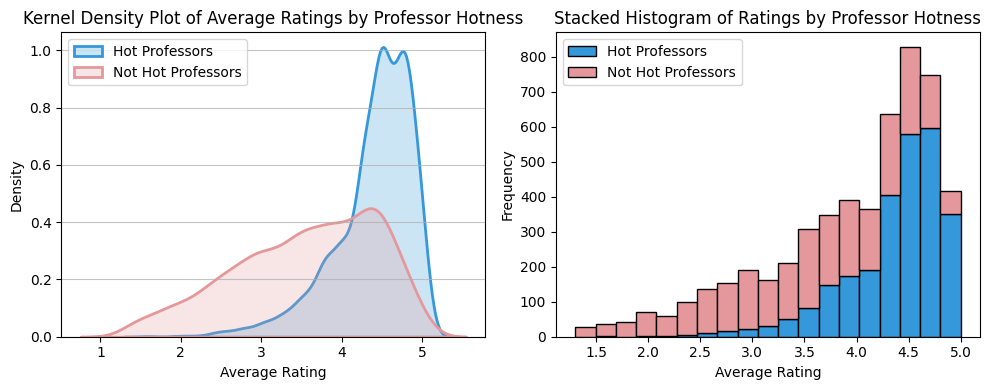

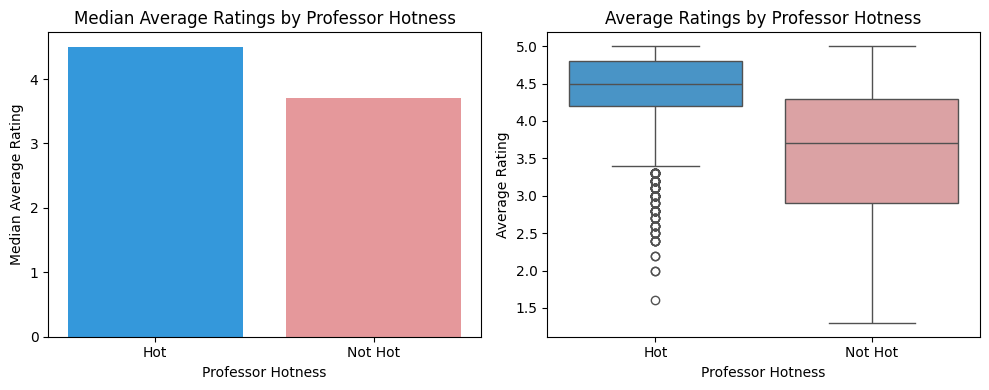

In [9]:
# =============================================================================
# 4. Do professors who are “hot” receive higher ratings than those who are not?
# =============================================================================

# Separates professors who received a pepper and professors who did not receive a pepper
yes_pepper = professor_wt[professor_wt["receive_pepper"] == 1]["avg_rating"]
no_pepper = professor_wt[professor_wt["receive_pepper"] == 0]["avg_rating"]

yes_median = np.median(yes_pepper)
yes_sd = np.std(yes_pepper)
yes_n = len(yes_pepper)
yes_se = yes_sd/np.sqrt(yes_n)

yes_data = pd.DataFrame([{
    "group": "Hot",
    "median": yes_median,
    "sd": male_sd,
    "n": yes_n,
    "se": yes_se
}])

descriptivesContainer_df = pd.concat([descriptivesContainer_df, yes_data], ignore_index=True)

no_median = np.median(no_pepper)
no_sd = np.std(no_pepper)
no_n = len(no_pepper)
no_se = no_sd/np.sqrt(no_n)

no_data = pd.DataFrame([{
    "group": "Not Hot",
    "median": no_median,
    "sd": no_sd,
    "n": no_n,
    "se": no_se
}])

descriptivesContainer_df = pd.concat([descriptivesContainer_df, no_data], ignore_index=True)

# Performs Mann-Whitney U test to assess if there hotter professors get higher ratings that professors who are not hot
u6, p_u6 = mannwhitneyu(yes_pepper, no_pepper, alternative='greater')

print(f"u6: {u6}, p_u6: {p_u6}")

if p_u6 < alpha:
    print("Reject the null hypothesis: Evidence suggests that 'hot' professors receive higher ratings.")
else:
    print("Fail to reject the null hypothesis: No evidence that 'hot' professors receive higher ratings.")

# COMBINED PLOTS
bins = np.linspace(min(yes_pepper.min(), no_pepper.min()), max(yes_pepper.max(), no_pepper.max()), 20)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Density plot
sns.kdeplot(yes_pepper, label='Hot Professors', fill=True, alpha=0.25, color='#3498db', linewidth=2, ax=axes[0])
sns.kdeplot(no_pepper, label='Not Hot Professors', fill=True, alpha=0.25, color='#E5989B', linewidth=2, ax=axes[0])
axes[0].set_xlabel('Average Rating')
axes[0].set_ylabel('Density')
axes[0].set_title('Kernel Density Plot of Average Ratings by Professor Hotness')
axes[0].legend(loc='upper left')
axes[0].grid(axis='y', alpha=0.75)

# Stacked histogram
axes[1].hist(
    [yes_pepper, no_pepper],
    bins=bins,
    stacked=True,
    color=["#3498db", "#E5989B"],
    label=["Hot Professors", "Not Hot Professors"],
    edgecolor='black'
)
axes[1].set_xlabel("Average Rating")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Stacked Histogram of Ratings by Professor Hotness")
axes[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

categories6 = ["Hot", "Not Hot"]
medians6 = [yes_median, no_median]

pepper_rating = pd.DataFrame({
    "Ratings": np.concatenate([yes_pepper, no_pepper]),
    "Professor Status": ["Hot"] * len(yes_pepper) + ["Not Hot"] * len(no_pepper)  # Rename here
})

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Barplot
axes[0].bar(categories6, medians6, color=["#3498db", "#E5989B"])
axes[0].set_xlabel("Professor Hotness")
axes[0].set_ylabel("Median Average Rating")
axes[0].set_title("Median Average Ratings by Professor Hotness")

# Boxplot
sns.boxplot(data=pepper_rating, x="Professor Status", y="Ratings", hue= "Professor Status", palette=["#3498db", "#E5989B"], ax=axes[1])
axes[1].set_xlabel("Professor Hotness")
axes[1].set_ylabel("Average Rating")
axes[1].set_title("Average Ratings by Professor Hotness")

plt.tight_layout()
plt.show()

### **Modeling (Predictions)**


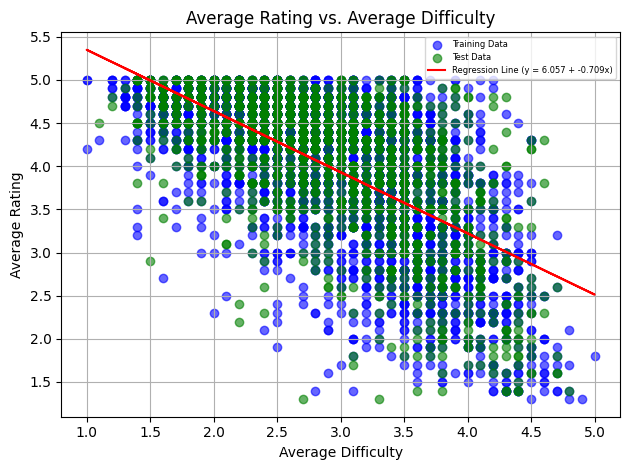


Train RMSE: 0.638
Test RMSE: 0.636
Train R^2: 0.404
Test R^2: 0.383
Coefficient (b1): -0.709
Intercept (b0): 6.057


In [10]:
# =============================================================================
# 5. Can we predict average rating from average difficulty?
# =============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt

X7 = professor_wt[["avg_difficulty"]]
y7 = professor_wt["avg_rating"]

X_train7, X_test7, y_train7, y_test7 = train_test_split(X7, y7, test_size=0.3, random_state=seed)

# Linear regression
linear = LinearRegression()
linear.fit(X_train7, y_train7)

# Coefficients
b1_7 = linear.coef_[0]
b0_7 = linear.intercept_

# Predictions
y_pred_train7 = linear.predict(X_train7)
y_pred_test7 = linear.predict(X_test7)

# RMSE
rmse_train7 = root_mean_squared_error(y_train7, y_pred_train7)
rmse_test7 = root_mean_squared_error(y_test7, y_pred_test7)

# R^2
r2_train7 = r2_score(y_train7, y_pred_train7)
r2_test7 = r2_score(y_test7, y_pred_test7)

# Scatterplot
plt.scatter(X_train7, y_train7, color="blue", alpha=0.6, label="Training Data")
plt.scatter(X_test7, y_test7, color="green", alpha=0.6, label="Test Data")
plt.plot(X_train7.values.flatten(), y_pred_train7, color="red",
         label=f"Regression Line (y = {b0_7:.3f} + {b1_7:.3f}x)")
plt.title("Average Rating vs. Average Difficulty")
plt.xlabel("Average Difficulty")
plt.ylabel("Average Rating")
plt.legend(prop={'size': 6})
plt.grid(True)

plt.tight_layout()
plt.show()

print()
print(f"Train RMSE: {rmse_train7:.3f}")
print(f"Test RMSE: {rmse_test7:.3f}")
print(f"Train R^2: {r2_train7:.3f}")
print(f"Test R^2: {r2_test7:.3f}")
print(f"Coefficient (b1): {b1_7:.3f}")
print(f"Intercept (b0): {b0_7:.3f}")

In [11]:
# =============================================================================
# 6. Can we predict average rating from all available factors?
# =============================================================================
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import statsmodels.api as sm

X8 = professor_wt[["avg_difficulty", "num_rating", "receive_pepper", "take_again", "num_rating_online", "is_male"]]
y8 = professor_wt["avg_rating"]

X_train8, X_test8, y_train8, y_test8 = train_test_split(X8, y8, test_size=0.3, random_state=seed)

# Encode categorical variables
cat_col = ['receive_pepper', 'is_male']
ohe = OneHotEncoder(sparse_output=False, drop='first')

encoder = make_column_transformer(
    (ohe, cat_col),
    remainder='passthrough'
)

# Pipe
pipe1 = Pipeline([
    ('encoder', encoder),  # Apply preprocessing
    ('model', linear)   # Fit linear regression
])

pipe1.fit(X_train8, y_train8)

# Predictions
y_pred_train8 = pipe1.predict(X_train8)
y_pred_test8 = pipe1.predict(X_test8)

# RMSE
rmse_train8 = root_mean_squared_error(y_train8, y_pred_train8)
rmse_test8 = root_mean_squared_error(y_test8, y_pred_test8)

# R^2
r2_train8 = r2_score(y_train8, y_pred_train8)
r2_test8 = r2_score(y_test8, y_pred_test8)

X_train8_encoded = pipe1.named_steps['encoder'].transform(X_train8)
X_train8_encoded = sm.add_constant(X_train8_encoded)

ols_model = sm.OLS(y_train8, X_train8_encoded).fit()

# OLS summary table
print(ols_model.summary())

print()
print(f"Train RMSE (Model 8): {rmse_train8:.3f}")
print(f"Test RMSE (Model 8): {rmse_test8:.3f}")
print(f"Train R^2 (Model 8): {r2_train8:.3f}")
print(f"Test R^2 (Model 8): {r2_test8:.3f}")

                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     2711.
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:28:35   Log-Likelihood:                -1390.3
No. Observations:                3661   AIC:                             2795.
Df Residuals:                    3654   BIC:                             2838.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7019      0.045     59.532      0.0

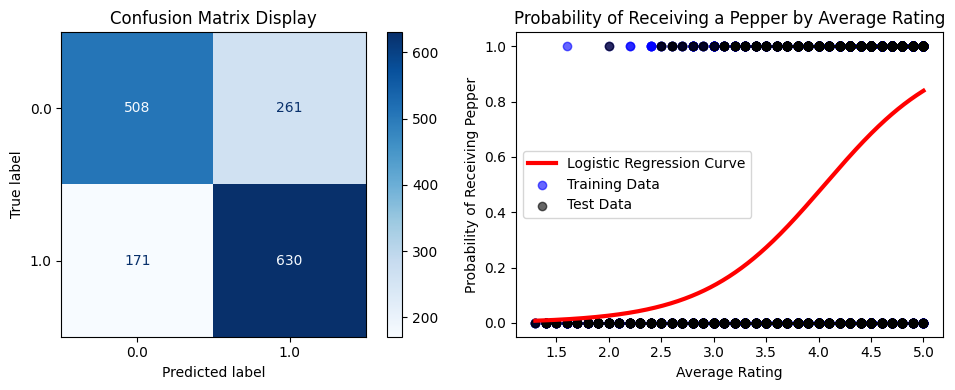

              precision    recall  f1-score   support

         0.0       0.75      0.66      0.70       769
         1.0       0.71      0.79      0.74       801

    accuracy                           0.72      1570
   macro avg       0.73      0.72      0.72      1570
weighted avg       0.73      0.72      0.72      1570



In [12]:
# =============================================================================
# 7. Can we predict whether a professor receives a 'pepper' based on their average rating?
# =============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.special import expit

logistic = LogisticRegression(class_weight='balanced')

pipe2 = Pipeline([
    ('model', logistic)
])

# Logistic regression
X9 = professor_wt[['avg_rating']]
y9 = professor_wt['receive_pepper']

X9_train, X9_test, y9_train, y9_test = train_test_split(X9, y9, test_size=0.3, random_state=seed, stratify=y9)

# pipe
pipe2.fit(X9_train, y9_train)

# Predict
y_prob_test9 = pipe2.predict_proba(X9_test)[:, 1]
y_pred_test9 = pipe2.predict(X9_test)

# Calculate metrics
classification9 = classification_report(y9_test, y_pred_test9)
confusion9 = confusion_matrix(y9_test, y_pred_test9)

model9 = pipe2.named_steps['model']  # Extract the logistic regression model
coef, intercept = model9.coef_[0][0], model9.intercept_[0]  # Coefficient and intercept

x91_train = np.linspace(X9_train.min(), X9_train.max(), 500).reshape(-1, 1)
sigmoid_train = expit(coef * x91_train + intercept)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Adjust size as needed

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(pipe2, X9_test, y9_test, cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix Display")

# Plot
axes[1].plot(x91_train, sigmoid_train.ravel(), color='red', linewidth=3, label="Logistic Regression Curve")
axes[1].scatter(X9_train, y9_train, color='blue', alpha=0.6, label="Training Data")
axes[1].scatter(X9_test, y9_test, color='black', alpha=0.6, label="Test Data")
axes[1].set_xlabel('Average Rating')
axes[1].set_ylabel('Probability of Receiving Pepper')
axes[1].set_title('Probability of Receiving a Pepper by Average Rating')
axes[1].legend()

plt.tight_layout()
plt.show()

# Classification report
print(classification9)

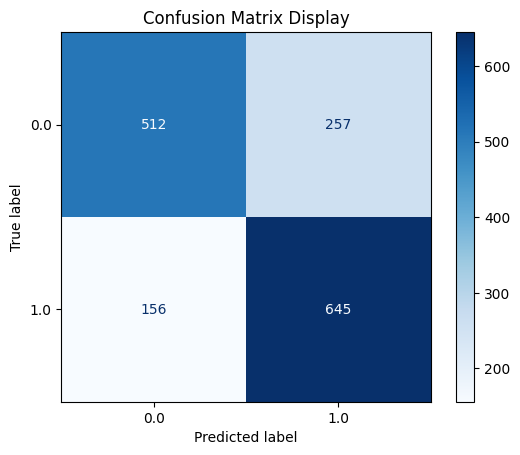

              precision    recall  f1-score   support

         0.0       0.77      0.67      0.71       769
         1.0       0.72      0.81      0.76       801

    accuracy                           0.74      1570
   macro avg       0.74      0.74      0.74      1570
weighted avg       0.74      0.74      0.74      1570



In [13]:
# =============================================================================
# 8. Can we predict whether a professor receives a 'pepper' from all available factors?
# =============================================================================
X10 = professor_wt[["avg_rating", "avg_difficulty", "num_rating", "take_again", "num_rating_online", "is_male"]]
y10 = professor_wt['receive_pepper']

X10_train, X10_test, y10_train, y10_test = train_test_split(X10, y10, test_size=0.3, random_state=seed, stratify=y10)

# Drop 'receive_pepper' from the encoder because it is now the dependent variable
drop_pepper = [col for col in cat_col if col != 'receive_pepper']

new_encoder = make_column_transformer(
    (ohe, drop_pepper),
    remainder='passthrough'
)

pipe3 = Pipeline([
    ('encoder', new_encoder),  # Preprocessing with encoder
    ('model', logistic)  # Logistic regression
])

# Pipe
pipe3.fit(X10_train, y10_train)

# Predictions
y_prob_test10 = pipe3.predict_proba(X10_test)[:, 1]  # Probability for the positive class
y_pred_test10 = pipe3.predict(X10_test)  # Predicted class labels

# Calculate metrics
classification10 = classification_report(y10_test, y_pred_test10)
confusion10 = confusion_matrix(y10_test, y_pred_test10)

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(pipe3, X10_test, y10_test, cmap="Blues")
plt.title("Confusion Matrix Display")
plt.show()

# Classification report
print(classification10)

In [14]:
# =============================================================================
# Descriptive container summary of each group tested
# =============================================================================
descriptivesContainer_df

,group,median,sd,n,se
0,Male,4.300000,0.799577,2957,0.014704
1,Female,3.939842,0.847120,2274,0.017764
2,High Experience,4.300000,0.831262,2441,0.016825
3,Low Experience,4.200000,0.812439,2790,0.015381
4,High Online,4.000000,0.927419,127,0.082295
5,Low Online,4.300000,0.817580,5104,0.011444
6,Hot,4.500000,0.799577,2669,0.009491
7,Not Hot,3.700000,0.876431,2562,0.017315
